#Import usefull packages and libraris

In [0]:
import numpy as np
import pdb
import matplotlib.pyplot as plt
import pandas  as pd
from google.colab import drive
from sklearn.preprocessing import  scale
import seaborn as sns
import imageio

#Mount the drive and read the images

In [39]:
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/prime_project/data/'  # your new root path
directory =  root_path+"/bee_imgs/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Perliminary EDA

We the *.csv* file containing metadata about The BeeImage Dataset.

In [40]:
df = pd.read_csv(root_path+"bee_data.csv")
n_tot = df['file'].count()
print("Total images in the dataset: {}".format(n_tot))
df.head()

Total images in the dataset: 5172


,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


Total images in the dataset: 5172


,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


For the purposes of the current work, we are only interested in associating each bee to the proper subspecies. For this reason, we are going to discard the images repsenting bees whose subspecies is unknown.

Images left: 4744
Images lost: 8.275328692962105%
Distinct values of subspecies = 6



Text(0.5, 0, 'Frequency')

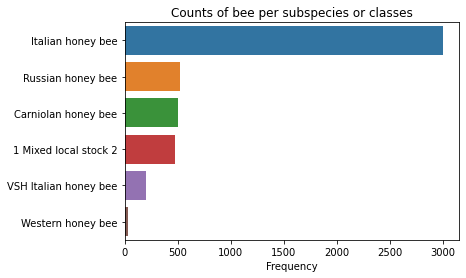

Images left: 4744
Images lost: 8.275328692962105%
Distinct values of subspecies = 6



Text(0.5, 0, 'Frequency')

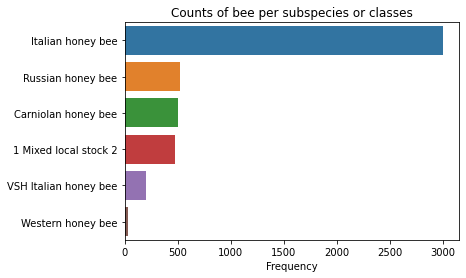

In [41]:
df = df[df['subspecies'] != '-1'] #remove images for which we do not have the class label
print("Images left: {}\nImages lost: {}%".format(df['file'].count(), 100-df['file'].count()/n_tot*100))
print("Distinct values of subspecies = {}\n".format(df["subspecies"].nunique()))
# print("Counting the distinct values of subspecies:\n{}".format(df["subspecies"].value_counts()))

subspecies_counts = df["subspecies"].value_counts()
plt.title("Counts of bee per subspecies or classes")
g = sns.barplot(x = subspecies_counts, y = subspecies_counts.index)
g.set_xlabel("Frequency")

#Load images and preprocess them

In [0]:
def get_image_data(directory, files):
    '''
   read the images
   @input:
   -directoryc: string containing the path to the files
   -files: list containing the file name of th eimages in the direcotry

   @returns:
   -an array of shape=(n_images,) where each element is an image of shape (width,heigth,rgb)
    
    '''
    return np.asanyarray([imageio.imread("{}{}".format(directory, file)) for file in files])

def show_image_shapes(images,n):
      """
      print the shape of n images choosen randomly
      """
      for i in range(n):
        r = np.random.randint(low=0, high=len(images))
        print("image number ",r," shape =",images[r].shape)

def show_image(image, ax = plt, title = None, show_size = False):
    '''Plots a given np.array image'''
    ax.imshow(image)
    if title:
        if ax == plt:
            plt.title(title)
        else:
            ax.set_title(title)
    if not show_size:
        ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
def show_images(images, titles = None, show_size = False):
    '''Plots many images from the given list of np.array images'''
    cols = 4
    f, ax = plt.subplots(nrows=int(np.ceil(len(images)/cols)),ncols=cols, figsize=(14,5))
    ax = ax.flatten()
    for i, image in enumerate(images):
        if titles:
            show_image(image, ax = ax[i], title = titles[i], show_size = show_size)
        else:
            show_image(image, ax = ax[i], title = None, show_size = show_size)
    plt.show()       

**LOAD IMAGES**

In [0]:
images = get_image_data(directory,df.file.values)

**VISUALIZE SOME IMAGES AND ALSO THE SHAPE**

In [44]:
show_image_shapes(images,3)

image number  574  shape = (194, 203, 3)
image number  405  shape = (80, 67, 3)
image number  1068  shape = (54, 56, 3)
image number  3560  shape = (52, 43, 3)
image number  2817  shape = (69, 80, 3)
image number  4030  shape = (60, 43, 3)


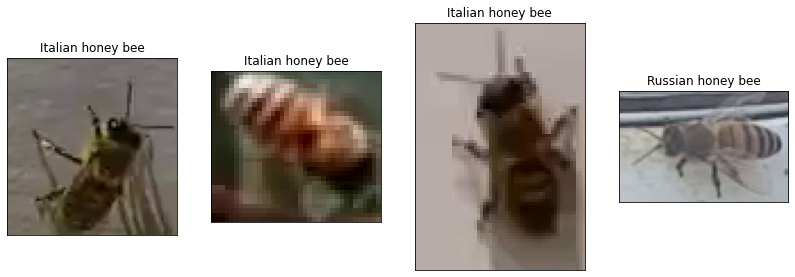

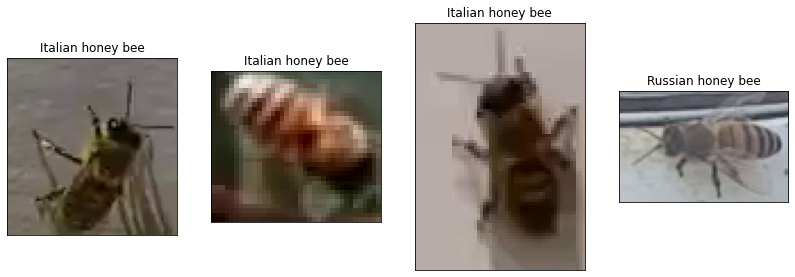

In [45]:
show_images(images[::1200],list(df["subspecies"][::1200]))

As we can see from the previous outputs, images basically have different shapes. However, in order to train our CNN, input images should have the same shape. Therefore, we will first reshape our input images in order to have the same shape.

We basically have the following possibilities:

 * reshape all images to the **smallest image size**: applying this technique will lead to a huge loos in data quality, which is not acceptable in our case since images already have a very low quality.

 * reshape all images to the **highest image size**: this technique may lead to noisy images and the network may not learn anything at all !!

 *our proposed approch is to find the **most frequent image shape** and use it to reshape our images. The intuition behind this technique is that it will allow to reshape only few images therefore, preserving data quality for most of our images. 

**FIND THE MOST FREQUENT SHAPES**

In [0]:
def get_images_wh(images):
    '''Returns a tuple of lists, representing the widths and heights of the given images, respectively.'''
    widths = []
    heights = []
    for image in images:
        h, w, rbg = image.shape
        widths.append(w)
        heights.append(h)
    return (widths, heights)

def get_best_average(dist, cutoff = .5):
    '''Returns an integer of the average from the given distribution above the cutoff.
    '''
    # requires single peak normal-like distribution
    hist, bin_edges = np.histogram(dist, bins = 25);
    total_hist = sum(hist)
    
    # associating proportion of hist with bin_edges
    hist_edges = [(vals[0]/total_hist,vals[1]) for vals in zip(hist, bin_edges)]
    
    # sorting by proportions (assumes normal-like dist such that high freq. bins are close together)
    hist_edges.sort(key = lambda x: x[0])
    lefts = []
    
    # add highest freq. bins to list up to cutoff % of total
    while cutoff > 0:
        vals = hist_edges.pop()
        cutoff -= vals[0]
        lefts.append(vals[1])
        
    # determining leftmost and rightmost range, then returning average
    diff = np.abs(np.diff(lefts)[0]) # same diff b/c of bins
    leftmost = min(lefts)
    rightmost = max(lefts) + diff
    return int(np.round(np.mean([rightmost,leftmost])))

In [0]:
wh = get_images_wh(images)

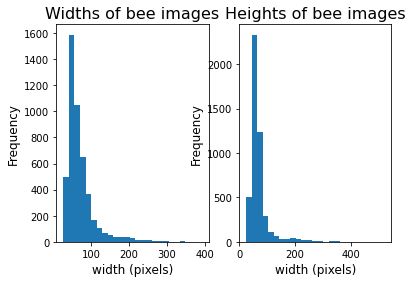

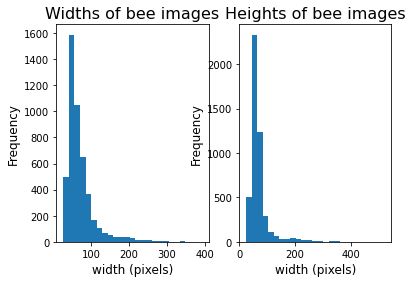

In [48]:
size = 12
plt.subplot(1,2,1)
plt.title("Widths of bee images", fontsize = size * 4/3, pad = size/2)
plt.ylabel("Frequency", size = size)
plt.xlabel("width (pixels)", size = size)
plt.hist(wh[0], bins = 25);
plt.subplot(1,2,2)

plt.title("Heights of bee images", fontsize = size * 4/3, pad = size/2)
plt.ylabel("Frequency", size = size)
plt.xlabel("width (pixels)", size = size)
plt.hist(wh[1], bins = 25);

we can notice that the distribution of **width** and **height** of images is very unbalanced. So we will consider only the **50%** most frequent weigth and width, then we will average them to determine the shape of our input images. This technique will allow to alter the least majority of the data.

*NOTE* :we could have defined width and heigth as the average over the width and shape of all the images. However, this technique should have not been efficient since the distrinution of the 2 variables is mainly concentrated around the interval **[48,78]**

In [49]:
IDEAL_WIDTH, IDEAL_HEIGHT = get_best_average(wh[0]), get_best_average(wh[1])
print("the ideal heigth and width for our images are ",IDEAL_HEIGHT,IDEAL_WIDTH) 

the ideal heigth and width for our images are  64 56
the ideal heigth and width for our images are  64 56


**RESIZING THE IMAGES**

in order to resize our images, we can use the python package *opencv* which already implement some usefull function to resize an image. 

In [0]:
import cv2

def resize_images(images,new_shape):
  """
  resize the entire data set of images
  @input
  -images: ndarray of shape=(n_images,) where each image if of shape (height,width,n_channel)
  -new_shape : a tuple (height,width)
 

  @returns:
  an ndarray representing the reshaped image dataset
  """
  reshaped = 0
  size = (new_shape[1],new_shape[0]) # because dsize should be (width,height)
  reshaped_images = []
  for image in images:
    if image.shape[2] != new_shape[2]:#this is a CYMK image
      reshaped += 1
      image = image[:,:,:3]
    image = cv2.resize(src=image,dsize= size, interpolation = cv2.INTER_AREA)
    reshaped_images.append(image)  
  print("WARNING :",reshaped," have images been trasfomr from CYMK to RGB by reshaping!!")
  return  np.asarray(reshaped_images)

def dataset_statistics(images):
 print("The total number of images is :",len(images))
 s = images[0].shape
 uniform = True
 for i in images:
   if i.shape != s:
    uniform = False
 if uniform:
   print("All images have the same shape which is ",s)
 else:
   print("WARNING: all images does not have the same shape,therefore it's not possible to train a CNN")     


In [51]:
n_channels = 3
new_shape = (IDEAL_HEIGHT,IDEAL_WIDTH,n_channels)
reshaped_image = resize_images(images,new_shape)

In [52]:
dataset_statistics(reshaped_image)

The total number of images is : 4744
All images have the same shape which is  (64, 56, 3)
The total number of images is : 4744
All images have the same shape which is  (64, 56, 3)


**NORMALIZE IMAGES** : TO BE DONE LATER TO SEE IF WE IMPROVW THE ACCURACY

In [0]:
def normalize_images(X):
  """
  function that allows to normalize pixels of the image between [0,1]

  @input
  -X: ndarray of shape=(n_images,heigth,width,n_channels)
  @returns
  -X : normalized dataset with the same shape
  """
  n_images,heigth,width,nb_channels = X.shape[0],X.shape[1],X.shape[2],X.shape[3]

  #Reshape the data-set in order to have 2-D array. it will trasform X from (n_images,h,w,channels) to --> (n_images,h*w*n_channels)
  X = np.reshape(X,newshape=(n_images,-1))
  X = scale(X)
  X = np.reshape(X,newshape=(n_images,heigth,width,nb_channels))

  return X

**We also need to encode the labels with integer values.**

In [54]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

le = LabelEncoder()
y = le.fit_transform(df.subspecies.values)
lablels_dictionaty = le.get_params() #get the dictionay of mapping between classes and indexes
y = np.array(y)
print(le.classes_)

Using TensorFlow backend.


['1 Mixed local stock 2' 'Carniolan honey bee' 'Italian honey bee'
 'Russian honey bee' 'VSH Italian honey bee' 'Western honey bee']
['1 Mixed local stock 2' 'Carniolan honey bee' 'Italian honey bee'
 'Russian honey bee' 'VSH Italian honey bee' 'Western honey bee']


**Now we can finally split the data for training and testing purposes.**

In [0]:

X_train, X_test, Y_train, Y_test = train_test_split(reshaped_image, y, test_size=0.2, random_state=2020)


In [56]:
print("X_train.shape = {}\nX_test.shape = {}\ny_train.shape = {}\ny_test.shape ={}"
      .format(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape))

X_train.shape = (3795, 64, 56, 3)
X_test.shape = (949, 64, 56, 3)
y_train.shape = (3795,)
y_test.shape =(949,)
X_train.shape = (3795, 64, 56, 3)
X_test.shape = (949, 64, 56, 3)
y_train.shape = (3795,)
y_test.shape =(949,)


# Building the CNN with Keras

**Define the network structure**

In [57]:
import tensorflow as tf

tf.reset_default_graph()
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
print(keras.__version__)

2.2.5
2.2.5


**load data with image generator :**


Data generators are on-the-fly image transformers and are the recommended
way of providing image data to models in Keras. They let you work with
on-disk image data too large to fit all at once in-memory. And they allow
you to preprocess the images your model sees with random image 
transformations and standardizations, a key technique for improving model
performance. To learn more, see https://keras.io/preprocessing/image/.

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(
    rescale=1/255,
)

train_datagen.fit(X_train)
test_datagen.fit(X_test)

In [0]:
Y_train_kereas = to_categorical(Y_train)
Y_test_kereas = to_categorical(Y_test)

In [0]:
learning_rate = 0.01
n_epochs = 4
batch_size = 64
nb_filters = 32
kernelSize = (3, 3)
pool_size = (2, 2)

img_rows, img_cols, nb_channels = new_shape
input_shape = (img_rows, img_cols, nb_channels)
nb_classes = Y_train_kereas.shape[1] 
# --- Size of the successice layers
n_h_0 = nb_channels
n_h_1 = nb_filters
n_h_2 = nb_filters
n_h_3 = nb_filters

In [61]:

model = Sequential()
filter_size = (3,3)
#the initialization of the kernel influences a lot the performance of the algorithm: different initializers have different impact.
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu',padding= "same",kernel_initializer= keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), input_shape=input_shape))

model.add(Conv2D(filters = nb_filters, kernel_size = filter_size, activation='relu',padding ="same", kernel_initializer= "random_uniform",name='conv_2'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(filters = nb_filters, kernel_size = filter_size, activation='relu',padding ="same",kernel_initializer= "random_uniform", name='conv_3'))
model.add(MaxPooling2D((2, 2), padding="same"))

model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax', kernel_initializer="random_uniform", name='dense_1'))

**compile the model, define the loss and the optimizer**

In [62]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=learning_rate),
              metrics=['accuracy'])

**plot the accuracy and the loss over epochs during training**

In [0]:
def plot_acc_loos(acc,loss):
  """
  plot the accuracy and the loss over epchos
  @input:
  -acc : array of shape=(n_epochs,) representing the accuracy of the model during training over epochs
  -loss: array of shape=(n_epochs,) representing the loss of the model during training
    """
  plt.plot(acc,"g",label="accuracy")
  plt.plot(loss,"r",label="loss")
  plt.xlabel("epoch")
    # plt.ylabel("metric")
  plt.legend()
  plt.show()

**summary of the model to have an idea of the architechture and the weigths that will be trained**

In [64]:
#the number of trainable of parameters at each layers is equal to total number of weight of all the filters at each layer.
#In this case 3*3(size of each filter) * 3(depth of each filter)*32(total number of filters at the first layer) + 32(each filter has a bias) = 896
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 56, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 64, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 28, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 32, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7168)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                

**train the model**

In [34]:
history = model.fit_generator(train_datagen.flow(x= X_train,y = Y_train_kereas,batch_size=batch_size,shuffle=True),
                    steps_per_epoch=len(X_train),
                    epochs=n_epochs,
                    verbose = 1)
# model.fit(X_train, Y_train_kereas,
#            batch_size=batch_size, 
#           epochs=n_epochs,
#           verbose=1, 
#           validation_data=(X_test, Y_test_kereas))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/4





3795/3795 [==============================] - 260s 68ms/step - loss: 0.5239 - acc: 0.8036
Epoch 2/4
3795/3795 [==============================] - 244s 64ms/step - loss: 0.2271 - acc: 0.8985
Epoch 3/4
3795/3795 [==============================] - 244s 64ms/step - loss: 0.1698 - acc: 0.9212
Epoch 4/4
3795/3795 [==============================] - 243s 64ms/step - loss: 0.1575 - acc: 0.9325
Epoch 1/4
3218/3795 [========================>.....] - ETA: 37s - loss: 0.1280 - acc: 0.9416

**evaluate the performances of the model on test data**

In [35]:
score = model.evaluate(X_test, Y_test_kereas, verbose=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

949/949 [==============================] - 0s 333us/step
Test score: 7.961928419870873
Test accuracy: 0.5057955747283799


**plot accuracy and the loss over epochs during training**

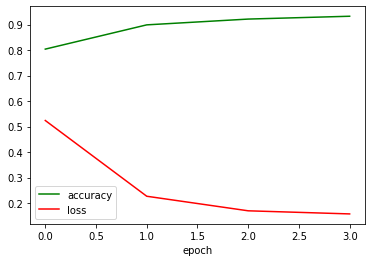

In [36]:
def plot_acc_loss(acc,loss):
  """
  plot the accuracy and the loss over epchos
  @input:
  -acc : array of shape=(n_epochs,) representing the accuracy of the model during training over epochs
  -loss: array of shape=(n_epochs,) representing the loss of the model during training
    """
  plt.plot(acc,"g",label="accuracy")
  plt.plot(loss,"r",label="loss")
  plt.xlabel("epoch")
    # plt.ylabel("metric")
  plt.legend()
  plt.show()

loss = history.history["loss"]
acc = history.history["acc"]
plot_acc_loss(acc,loss)    

**plot the confusion matrix in other to evaluate the overall performance of the network**

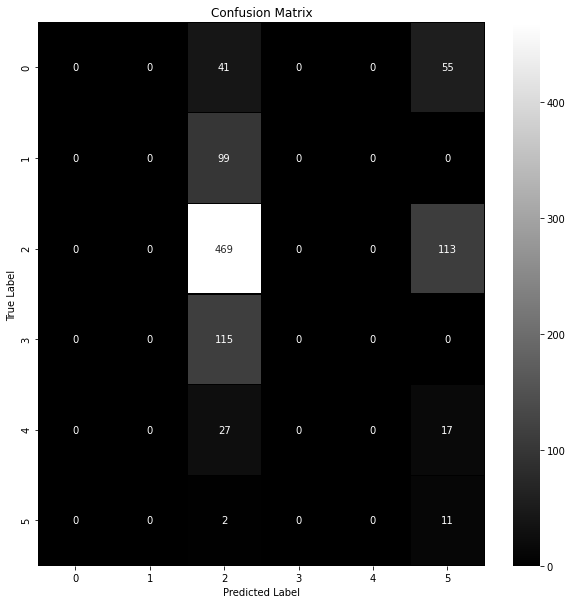

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_test_kereas, axis = 1)
confusionMatrix = confusion_matrix(Y_true, Y_pred_classes)
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(confusionMatrix, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

As first interpretation, we can notice that the bias we had in input is replicated in output because the model learns very well how to predict **italian honey bee** since it's the dominan in the dataset. Moreover, the classifer tends to classify rare classes as belonging to **italian honey bee class** as we can see from column 2 of the confusion matrix.

#Apply ZCA preprocessing technique to improve the accuracy